In [1]:
import numpy as np
import pandas as pd

import pystan
import arviz

import matplotlib.pyplot as plt

In [2]:
smoking_data = pd.read_table("../utilities_and_data/smoking/smoke_pub.dat")

In [77]:
smoking_data["total_waves_smoked"] = smoking_data.groupby("newid")["smkreg"].transform("sum")
never_smokers = smoking_data["total_waves_smoked"] == 0

never_smokers_test_statistic_y = (smoking_data.groupby("newid")["smkreg"].agg("sum") == 0).mean()

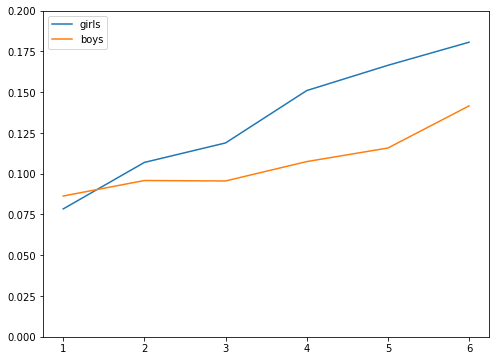

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(smoking_data.loc[smoking_data["sex(1=F)"] == 1].groupby("wave")["smkreg"].mean(), label="girls");
ax.plot(smoking_data.loc[smoking_data["sex(1=F)"] == 0].groupby("wave")["smkreg"].mean(), label="boys");
ax.set_ylim(0, 0.2);
ax.legend();

In [4]:
num_people = smoking_data["newid"].nunique()

In [5]:
model = pystan.StanModel("model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9c2abc7e97a92f86f06ca15393b66477 NOW.


In [6]:
stan_data = {
    "N_people": num_people,
    "N": len(smoking_data),
    "parent_smoke": smoking_data["parsmk"],
    "female": smoking_data["sex(1=F)"],
    "t": smoking_data["wave"],
    "smoke": smoking_data["smkreg"],
    "p_idx": smoking_data["newid"]
}

In [7]:
fit = model.sampling(stan_data, iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
params = fit.extract(permuted=True)
var_names=["b0", "b1", "b2", "b3", "b4", "sigma_alpha"]

In [15]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data, var_names=var_names)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [18]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b0,-8.505,0.493,-9.411,-7.586,0.020,0.014,587.0,582.0,588.0,806.0,1.01
1,b1,2.547,0.341,1.947,3.203,0.016,0.011,481.0,481.0,480.0,1055.0,1.01
2,b2,-0.450,0.463,-1.299,0.411,0.017,0.012,732.0,732.0,733.0,1139.0,1.01
3,b3,0.356,0.055,0.250,0.449,0.001,0.001,2563.0,2493.0,2546.0,1322.0,1.00
4,b4,0.529,0.054,0.424,0.626,0.001,0.001,3454.0,3209.0,3555.0,1840.0,1.00
5,sigma_alpha,4.988,0.271,4.503,5.492,0.012,0.009,502.0,500.0,509.0,1370.0,1.01


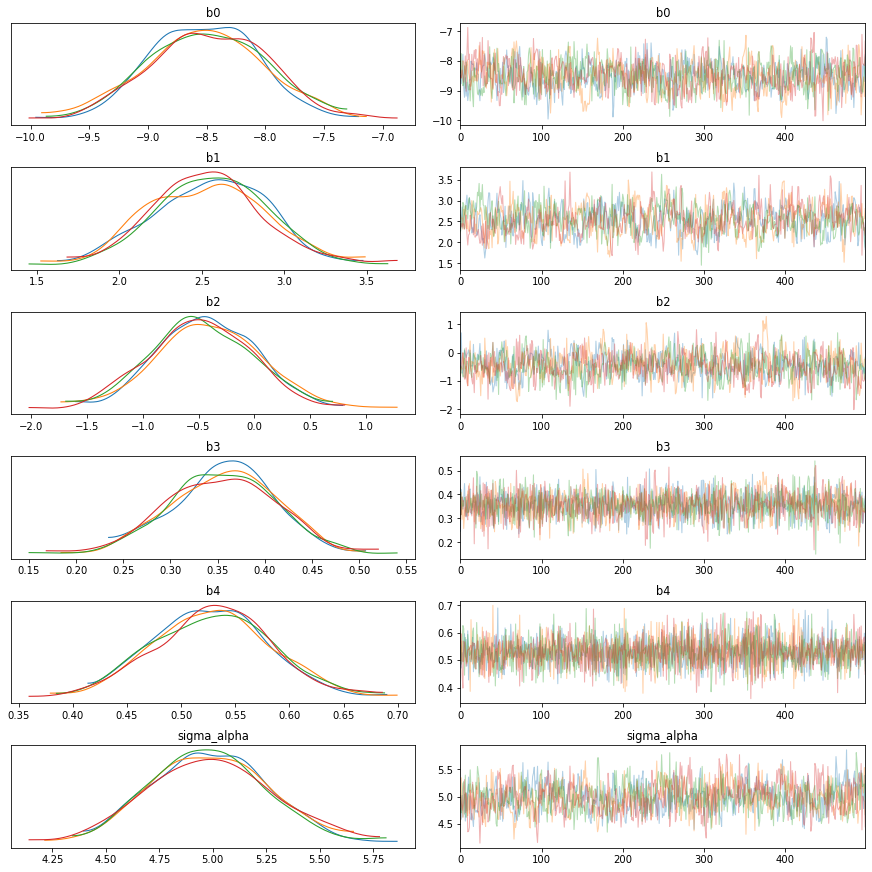

In [16]:
arviz.plot_trace(fit, var_names=var_names);

In [67]:
df_y_rep = pd.DataFrame(params["y_pred"]).T
df_y_rep["newid"] = smoking_data["newid"].values

never_smokers_y_rep = df_y_rep.groupby("newid").sum().values
never_smokers_test_statistic = (never_smokers_y_rep == 0).mean(0)
qs = np.quantile(never_smokers_test_statistic, q=[0.025, 0.975])

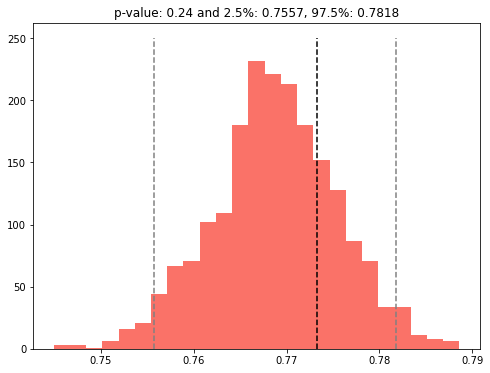

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(never_smokers_test_statistic, bins=25, color="#fa7268");
ax.vlines(qs[0], 0, 250, linestyle="--", color="grey");
ax.vlines(qs[1], 0, 250, linestyle="--", color="grey");
ax.vlines(never_smokers_test_statistic_y, 0, 250, linestyle="--", label="$T(y)$");
ax.set_title(f"p-value: {(np.mean(never_smokers_test_statistic > never_smokers_test_statistic_y)):.2f} and 2.5%: {qs[0]:.4f}, 97.5%: {qs[1]:.4f}");